**quantrautil**- this will be used to fetch the price data of the BAC stock from yahoo finance.
**numpy**-to perform the data manipulation on BAC stock price to compute the input features and output. If you want to read more about numpy then it can be found here.
**sklearn** a library that contains a large number of machine learning models
At this time, we need the 

*Next step*: fetch the data: from quantrautil is used to get the BAC data for 19 years from 1 Jan 2000 to 31 Jan 2019.
*Write out as CSV*https://medium.com/@kasiarachuta/importing-and-exporting-csv-files-in-python-7fa6e4d9f408

In [22]:
import qntutl as q
import numpy as np
from sklearn.ensemble import RandomForestClassifier

**Fetch the data**
The next step is to import the price data of BAC stock from quantrautil. The get_data function from quantrautil is used to get the BAC data for 19 years from 1 Jan 2000 to 31 Jan 2019 as shown below. The data is stored in the dataframe data.

In [27]:
data = q.get_data('BAC','2000-1-1','2019-2-1')
print(data.tail())
data.to_excel("output1.xlsx")
#example: export data into a xlsx file named output1.xlsx in the current directory. 

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2019-01-25  29.280001  29.719999  29.139999  29.580000  28.342173   72182100   
2019-01-28  29.320000  29.670000  29.290001  29.629999  28.390079   59963800   
2019-01-29  29.540001  29.700001  29.340000  29.389999  28.160124   51451900   
2019-01-30  29.420000  29.469999  28.950001  29.070000  27.853516   66475800   
2019-01-31  28.750000  28.840000  27.980000  28.469999  27.278620  100201200   

           Source  
Date               
2019-01-25  Yahoo  
2019-01-28  Yahoo  
2019-01-29  Yahoo  
2019-01-30  Yahoo  
2019-01-31  Yahoo  


**Creating input and output dataset**
1:Input variable: I have used '(Open - Close)/Open', '(High - Low)/Low', standard deviation of last 5 days returns (std_5), and average of last 5 days returns (ret_5)
2: Output variable: If tomorrow’s close price is greater than today's close price then the output variable is set to 1 and otherwise set to -1. 1 indicates to buy the stock and -1 indicates to sell the stock.


In [6]:
# Features construction 
data['Open-Close'] = (data.Open - data.Close)/data.Open
data['High-Low'] = (data.High - data.Low)/data.Low
data['percent_change'] = data['Adj Close'].pct_change()
#Reference:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html
data['std_5'] = data['percent_change'].rolling(5).std()
data['ret_5'] = data['percent_change'].rolling(5).mean()
data.dropna(inplace=True)

# X is the input variable
X = data[['Open-Close', 'High-Low', 'std_5', 'ret_5']]

# Y is the target or output variable
y = np.where(data['Adj Close'].shift(-1) > data['Adj Close'], 1, -1)

**Train test split**
We now split the dataset into 75% Training dataset and 25% for Testing dataset.

In [7]:
# Total dataset length
dataset_length = data.shape[0]
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shape.html#pandas.DataFrame.shape

# Training dataset length
split = int(dataset_length * 0.75)
split

3596

In [8]:
# Splitiing the X and y into train and test datasets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3596, 4) (1199, 4)
(3596,) (1199,)


## Train the machine learning Model
# Target: train a decision-classifier model
The RandomForestClassifier function from tree is stored in variable ‘clf’ and then a fit method is called on it with ‘X_train’ and ‘y_train’ dataset as the parameters so that the classifier model can learn the relationship between input and output.

In [10]:
clf = RandomForestClassifier(random_state=5)

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html (RandomForestClassifier)

In [15]:
# Create the model on train dataset
model = clf.fit(X_train, y_train)

Reference: https://lmfit.github.io/lmfit-py/examples/example_use_pandas.html (fit)

In [16]:
from sklearn.metrics import accuracy_score
print('Correct Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0)

Correct Prediction (%):  52.293577981651374


Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html (accuracy_score)

**Evaluation**
*report*

In [17]:
# Run the code to view the classification report metrics
from sklearn.metrics import classification_report
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

          -1       0.52      0.55      0.53       594
           1       0.53      0.50      0.51       605

    accuracy                           0.52      1199
   macro avg       0.52      0.52      0.52      1199
weighted avg       0.52      0.52      0.52      1199



*Strategy Returns*

In [19]:
data['strategy_returns'] = data.percent_change.shift(-1) * model.predict(X)
#shift(-1) remove the last row

reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html (shift)

*Daily returns histogram*

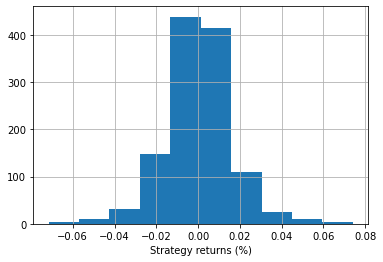

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
data.strategy_returns[split:].hist()
plt.xlabel('Strategy returns (%)')
plt.show()

*Strategy Returns*

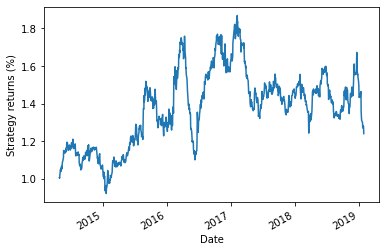

In [21]:
(data.strategy_returns[split:]+1).cumprod().plot()
plt.ylabel('Strategy returns (%)')
plt.show()

Reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumprod.html (cumprod)